In [5]:
import os
from datetime import date

import plotly.graph_objs as go
import plotly.offline as pyo

from Classfile import *
from pre_processing import cluster_df_list, cluster_name_list

In [6]:
# output paths
main = "/Users/alena/Library/CloudStorage/OneDrive-Personal/Work/PhD/Isochrone_Archive/Coding/"
subdir = date.today()
output_path = os.path.join(main, str(subdir))
try:
    os.mkdir(output_path)
except FileExistsError:
    pass
output_path = output_path + "/"

In [7]:
cluster_df_list.pop(1)
cluster_name_list.pop(1)

Archive_clusters = np.concatenate(cluster_name_list, axis=0)
Archive_df = pd.concat(cluster_df_list, axis=0)

In [3]:
# create traces for each line
traces = []
for col in Archive_df.columns[1:]:
    trace = go.Scatter(x=df['x'], y=df[col], mode='lines', name=col, visible=False)
    traces.append(trace)

# make first trace visible
traces[0]['visible'] = True

# create layout with slider
layout = go.Layout(title='Multiple Line Plot with Slider',
                   xaxis=dict(title='X-axis'),
                   yaxis=dict(title='Y-axis'),
                   sliders=[dict(active=0,
                                 currentvalue={'prefix': 'Line: '},
                                 pad={'t': 50},
                                 steps=[dict(label=col,
                                             method='update',
                                             args=[{'visible': [True if trace.name == col or trace.visible else False for trace in traces]}])
                                        for col in df.columns[1:]])])

# create figure
fig = go.Figure(data=traces, layout=layout)

# plot figure
pyo.plot(fig, filename='line_plot_with_slider.html')

'line_plot_with_slider.html'

In [3]:
def SVR_Hyperparameter_tuning(array, name, grid_dict: dict = None, output_file = None):
    X = array[:, 0].reshape(len(array[:, 0]), 1)
    Y = array[:, 1]

    # 2. Split X and Y into training and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=13)

    # 3. Scale training and test set wrt. to the training set
    X_mean = np.mean(X_train)
    X_std = np.std(X_train)
    X_train_scaled = (X_train - X_mean) / X_std
    X_test_scaled = (X_test - X_mean) / X_std
    X_scaled = np.array((X - X_mean) / X_std)
    Y_flat = Y_train.ravel()

    # 4. Define 5-fold cross validation
    rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=13)

    # 5. Create parameter grid
    if grid_dict is None:
        kernels = ["rbf"]
        C_range = np.logspace(-1, 2, 10)
        # gamma_range = np.logspace(-5, 2, 8)
        epsilon_range = np.logspace(-6, 1, 10)

        # svr_grid_rbf = dict(kernel=kernels, gamma=gamma_range, C=C_range)

        grid = [
            dict(kernel=kernels, gamma=["auto"], C=C_range,
                 epsilon=epsilon_range), ]

    else:
        grid = [grid_dict, ]

    Y_flat = Y_train.ravel()

    # 6. call the gridsearch function
    ranking = gridsearch_and_ranking(X_train_scaled, Y_flat, grid, rkf)
    #print("fin")

    # 7. Write output to file
    if output_file:
        df_row = pd.DataFrame(ranking.params[0], index = [0])

        df_row.insert(0,"Name", name, False)
        df_row.insert(5,"score", ranking.mean_test_score[0], True)
        df_row.insert(6,"std", ranking.std_test_score[0], True)

        df_row.to_csv(output_file, mode = "a", header = False)
        #with open(output_file, 'w') as f:
         #   print(ranking.params[0],file = f)
    else:
        print(ranking.params[0])
        print("score:", ranking.mean_test_score[0])
        print("std:", ranking.std_test_score[0])

    # 8. return params for check
    return ranking.params[0]

In [1]:
import os
from datetime import date

import numpy as np
import pandas as pd

from pre_processing import *
from Classfile import *
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from astropy.io import fits


## Stefans ESS clusters

In [20]:
CII_raw = "/Users/alena/PycharmProjects/PaperI/data/Cluster_data/Meingast_ESSV/Meingast_BCD_ages.csv"

CII_cols = ["Cluster_1", "parallax_EDR3", "parallax_error_EDR3", "phot_g_mean_mag_corrected", "phot_bp_mean_mag_EDR3",
           "phot_rp_mean_mag_EDR3", "phot_g_mean_mag_error_corrected", "phot_bp_mean_mag_error",
           "phot_rp_mean_mag_error",
           "bp_rp"]

CII_names = ["Cluster_id", "plx", "e_plx", "G_mag", "BP_mag", "RP_mag", "e_G_mag", "e_BP_mag", "e_RP_mag", "BP_RP"]

CII_clusters, CII_df = create_df(CII_raw, CII_cols, CII_names)

In [21]:
N = []
j = 0
for i, cluster in enumerate(CII_clusters[:]):
    OC = star_cluster(CII_clusters[i], CII_df)
    #setattr(OC,"age",OC.data.age.unique()[0])
    #setattr(OC,"Catalog",OC.data.Catalog.unique()[0])
    N.append(OC.Nstars)

print("Min", np.min(N), "Max", np.max(N))

Min 328 Max 1860


## Sebastians catalog

In [25]:
ScoCen_seb = "/Users/alena/PycharmProjects/PaperI/data/Cluster_data/Sco-Cen/Sco-Cen-young_Seb_X_EDR3.csv"

df_columns = ["cluster_name", "parallax", "parallax_error", "phot_g_mean_mag_corrected", "phot_bp_mean_mag_DR3",
              "phot_rp_mean_mag_DR3", "phot_g_mean_mag_error_corrected", "phot_bp_mean_mag_error",
              "phot_rp_mean_mag_error", "bp_rp_DR3",
              "ruwe_DR3", "phot_bp_rp_excess_factor_corrected", "stability", "age_lts", "age_t-dist"]

new_colnames = ["Cluster_id", "plx", "e_plx", "G_mag", "BP_mag", "RP_mag", "e_G_mag", "e_BP_mag", "e_RP_mag", "BP_RP",
                "ruwe", "bp_rp_excess_factor", "stability", "age_lts", "age"]

ScoCen_clusters, ScoCen_df = create_df(ScoCen_seb, columns=df_columns, names=new_colnames, name_dict=None,
                                       label_col=None, excess=0.025)

# Sebastians ages are Myr --> transform them to log(age)
ScoCen_df.age = np.log10(ScoCen_df.age*10**6)


ScoCen_df["Catalog"] = "Sco-Cen"

In [26]:
N = []
j = 0
for i, cluster in enumerate(ScoCen_clusters[:]):
    OC = star_cluster(ScoCen_clusters[i], ScoCen_df)
    setattr(OC,"age",OC.data.age.unique()[0])
    setattr(OC,"Catalog",OC.data.Catalog.unique()[0])
    if OC.Nstars >= 100:
        print(j)
        j+=1
        N.append(OC.Nstars)

print("Min", np.min(N), "Max", np.max(N))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Min 154 Max 1140


## Archive clusters Cantat-Gaudin

In [27]:
CI_raw = "/Users/alena/PycharmProjects/PaperI/data/Cluster_data/Cantat-Gaudin/Cantat-Gaudin_Xmatch_GAIA_with_CBD_ages.csv"

CI_cols = ["Cluster_1a", "parallax_EDR3", "parallax_error_EDR3", "phot_g_mean_mag_corrected", "phot_bp_mean_mag_EDR3",
           "phot_rp_mean_mag_EDR3", "phot_g_mean_mag_error_corrected", "phot_bp_mean_mag_error",
           "phot_rp_mean_mag_error",
           "bp_rp_EDR3"]#, "logage"]

CI_names = ["Cluster_id", "plx", "e_plx", "G_mag", "BP_mag", "RP_mag", "e_G_mag", "e_BP_mag", "e_RP_mag", "BP_RP"]#, "age"]

CI_clusters, CI_df = create_df(CI_raw, CI_cols, CI_names)
CI_df["Catalog"] = "CI"

In [28]:
N = []

for i, cluster in enumerate(CI_clusters[:]):

    OC = star_cluster(CI_clusters[i], CI_df)
    #setattr(OC,"age",OC.data.age.unique()[0])
    #setattr(OC,"Catalog",OC.data.Catalog.unique()[0])
    N.append(OC.Nstars)

print("Min", np.min(N), "Max", np.max(N))

Min 109 Max 1856


In [6]:
Hyperparam_output = "/Users/alena/PycharmProjects/PaperI/data/Hyperparameters/"

In [7]:
Archive_clusters = np.concatenate([CI_clusters,ScoCen_clusters], axis = 0)
Archive_df = pd.concat([CI_df,ScoCen_df], axis = 0)

In [8]:
data_coll = np.empty(shape=(81,5), dtype=object)

In [9]:
j = 0
for i, cluster in enumerate(Archive_clusters[:]):
    OC = star_cluster(Archive_clusters[i], Archive_df)
    setattr(OC,"age",OC.data.age.unique()[0])
    setattr(OC,"Catalog",OC.data.Catalog.unique()[0])


    if OC.Nstars > 98:
        data_coll[j,0] = OC.name
        data_coll[j,1] = OC.age
        data_coll[j,2] = OC.Catalog
        OC.kwargs_CMD["s"] = 50

        pca = PCA(n_components=2)
        pca_arr = pca.fit_transform(OC.CMD)

        try:
            HP_df = pd.read_csv(Hyperparam_output + "HP.csv")
            cluster_row = HP_df.loc[HP_df['Name'] == OC.name]
            params = cluster_row[["C", "epsilon", "gamma", "kernel"]].to_dict(orient="records")[0]
        except FileNotFoundError:

            evals = np.logspace(-2, -1.5, 20)
            #gvals = np.logspace(-4, -1, 50)
            Cvals = np.logspace(-2, 2, 20)

            param_grid = dict(kernel=["rbf"], gamma=["scale"], C=Cvals,
                                 epsilon=evals)

            params = SVR_Hyperparameter_tuning(pca_arr,OC.name, param_grid, output_file= Hyperparam_output + "HP.csv")

        svr = SVR(**params)

        svr_predict = pca_arr[:, 0].reshape(len(pca_arr[:, 0]), 1)

        X = pca_arr[:, 0].reshape(len(pca_arr[:, 0]), 1)
        Y = pca_arr[:, 1]

        Y_all = svr.fit(X, Y).predict(svr_predict)
       # print("SVR Test score:", svr.score(svr_predict, Y.ravel()))

        SVR_all = np.stack([svr_predict[:, 0], Y_all], 1)
        SVR_all = SVR_all[SVR_all[:, 1].argsort()][::-1]
        rev_transform = pca.inverse_transform(SVR_all)
        sorted_rev = rev_transform[rev_transform[:,1].argsort()]
        #cr  = int(0.05 * len(sorted_rev[:, 0]))
        cr = 0
        setattr(OC,"SVR_isochrone_x",list(rev_transform[:,0]))
        setattr(OC,"SVR_isochrone_y",list(rev_transform[:,1]))
        data_coll[j,3] = list(sorted_rev[cr:,0])
        data_coll[j,4] = list(sorted_rev[cr:,1])
        j+=1
        '''
        cmd = plt.figure(figsize =(4,5))
        plt.scatter(OC.CMD[:,0], OC.CMD[:,1], **OC.kwargs_CMD)
        plt.plot(sorted_rev[cr:,0], sorted_rev[cr:,1], color = "red")
        plt.title(OC.name)
        plt.gca().invert_yaxis()
        plt.close()
        cmd.savefig(output_path +"{}.png".format(OC.name), dpi = 400)
        '''



In [10]:
df =pd.DataFrame(data_coll,columns = ["name", "age","Catalog", "BP-RP", "G"])
df.sort_values("age", inplace = True, ascending = True)
df_wide = df.explode(["BP-RP", "G"])

In [11]:
df_wide.head()

,name,age,Catalog,BP-RP,G
78,rho Oph_L1688,6.491362,Sco-Cen,-0.850179,-0.458665
78,rho Oph_L1688,6.491362,Sco-Cen,0.567074,2.820704
78,rho Oph_L1688,6.491362,Sco-Cen,0.790879,3.337619
78,rho Oph_L1688,6.491362,Sco-Cen,0.869036,3.518167
78,rho Oph_L1688,6.491362,Sco-Cen,1.015661,3.857415


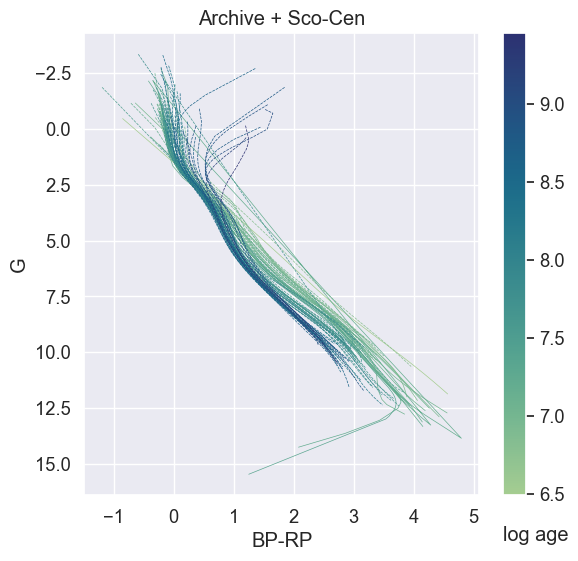

In [18]:
sns.set_palette("crest")

norm = plt.Normalize(df_wide.age.min(), df_wide.age.max())
sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
sm.set_array([])

Summary_fig = plt.figure()


sns.lineplot(data = df_wide, x= "BP-RP", y = "G", hue = "age", palette = "crest", hue_norm=norm, legend=False, sort =False
             , lw = 0.5, style = "Catalog")
plt.gca().invert_yaxis()



c= Summary_fig.colorbar(sm,  location='right', fraction = 0.1)
cax = c.ax
cax.text(0,6.2,'log age')


Summary_fig.set_figheight(6)
Summary_fig.set_figwidth(6)
sns.set(font_scale=1.2)
plt.title("Archive + Sco-Cen")
plt.show()

Summary_fig.savefig(output_path + "Summary_plot_CI_Sco-Cen_rev_nolegend.pdf", dpi=500)

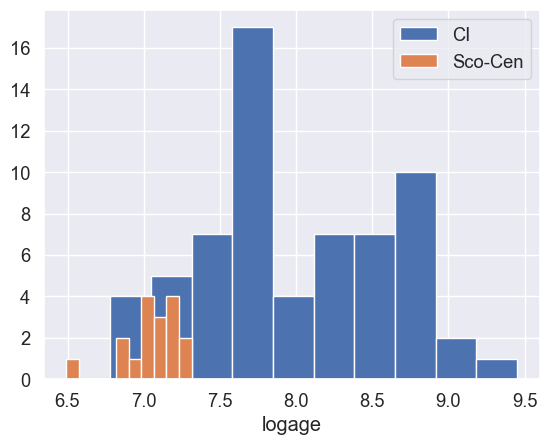

In [17]:
Sco_Cen_ages = df[df["Catalog"]== "Sco-Cen"]
CI_ages = df[df["Catalog"]== "CI"]

plt.hist(x = CI_ages["age"], label ="CI")
plt.hist(x = Sco_Cen_ages["age"], label = "Sco-Cen")

plt.legend(loc="upper right")
plt.xlabel("logage")

plt.savefig(output_path+"Age_histograms.pdf", dpi = 500)